<a href="https://colab.research.google.com/github/sumankanukollu/EVA_4_Assignments/blob/S_10_LRFinder_Misclassified_Cifar10/EVA4_S11_OneCyclePolicy_Suman.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Set the drive location

In [2]:
import os,sys

os.chdir('/content/drive/My Drive/pytorch_Framework_suman')
homepath  = os.getcwd()
print('\n### Home Path is : {}'.format(homepath))
!ls
sys.path.append(os.path.join(homepath,'lib'))


### Home Path is : /content/drive/My Drive/pytorch_Framework_suman
25_misclassifiedGradCamImages.jpg
data
EVA-4-S10-Suman-Kanukollu-LRFinder_CIFAR_10.ipynb
EVA_4_S11_Praveen_Raghuvanshi_Main.ipynb
EVA4_S11_Suman.ipynb
EVA-4-S11-Suman-Kanukollu-CIFAR_10.ipynb
EVA-4-S9-Suman-Kanukollu-Main.ipynb
lib
metrics.png
misclassified.png
models
outputs
pytorch_OCP_EVA4_S11_Suman.ipynb
resnet18_cifar10_main.ipynb
sampleImages
utils


# Set device

In [3]:
import torch
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
print(torch.cuda.is_available())

cuda
True


#  Prepare Dataset

In [0]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

from lib.loadDataSet import dataSetFunctions

dsObj   =   dataSetFunctions()

In [5]:
# Data transforms (normalization & data augmentation)
from lib.cutout import Cutout
stats = ((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
train_tfms = tt.Compose([tt.RandomCrop(32, padding=4, padding_mode='reflect'), 
                         tt.RandomHorizontalFlip(), 
                         tt.ToTensor(), 
                         Cutout(n_holes=1, length=8),
                         tt.Normalize(*stats)])
test_tfms = tt.Compose([tt.ToTensor(), tt.Normalize(*stats)])

(trainset,testset)    =   dsObj.dataSet(transform=(train_tfms,test_tfms),name='cifar10')


### Preparing dataset for the name : cifar10
Files already downloaded and verified
Files already downloaded and verified


In [6]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomCrop(size=(32, 32), padding=4)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.201))
           )

# Print one image from the train dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>
Image label is : frog


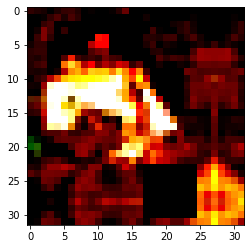

In [7]:
from matplotlib import pyplot as plt
def show_imgs(img,label):
    print(type(img))
    print('Image label is : {}'.format(trainset.classes[label]))
    plt.imshow(img.permute(1, 2, 0))

show_imgs(*trainset[0])

In [0]:
from torch.utils.data import DataLoader
batch_size = 512
# PyTorch data loaders
train_dl = DataLoader(trainset, batch_size, shuffle=True, 
                      num_workers=8, pin_memory=True)
valid_dl = DataLoader(testset, batch_size, shuffle=False, 
                      num_workers=8, pin_memory=True)

# Display Images from the Train Data Loader

In [0]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [0]:
def show_batch(dl,numOfImagesToDisplay=100,imgsPerRow=10):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(26, 26))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images[:numOfImagesToDisplay], imgsPerRow).permute(1, 2, 0))
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


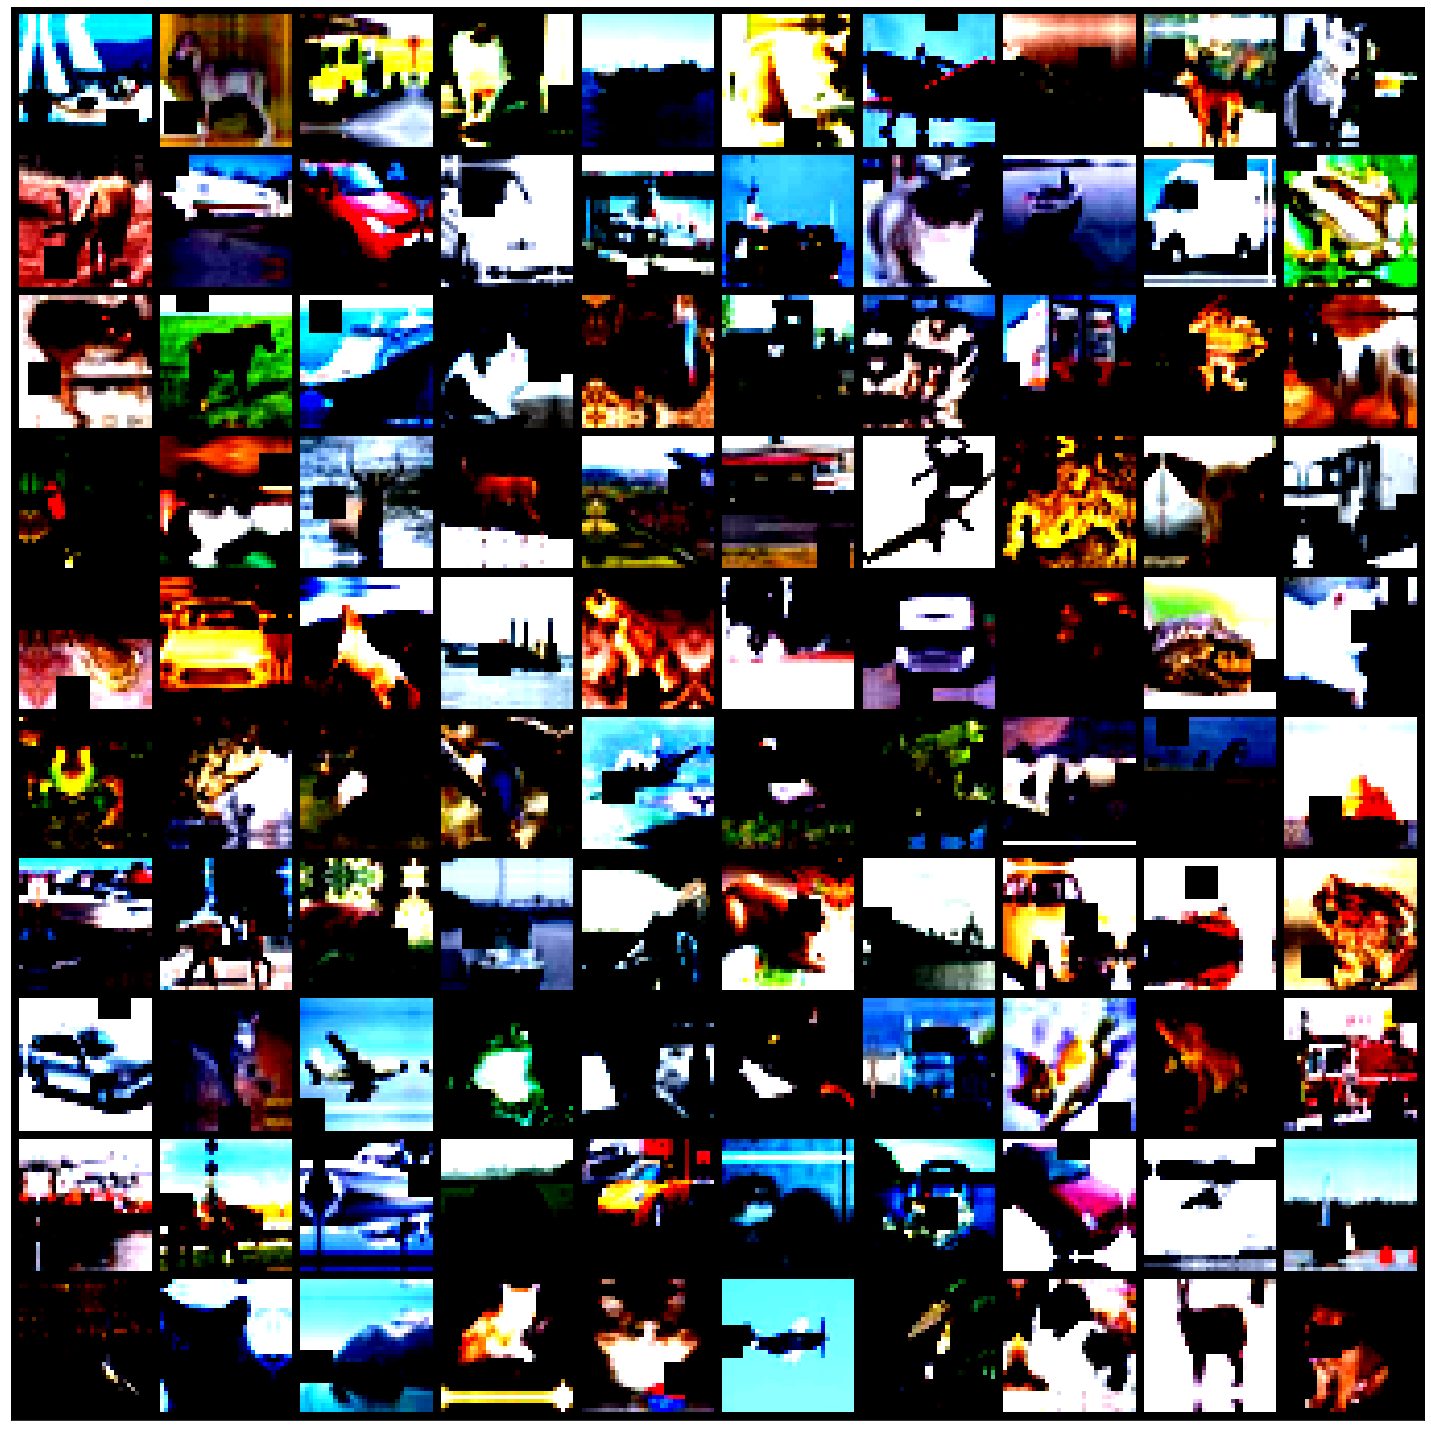

In [11]:
show_batch(train_dl)

# Import EVA-4 Session-11 Model


In [0]:
from models.resnet import *


In [13]:
from torchsummary import summary
model =s11Model().to(device)

summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

# Test the model what we have written

In [14]:
for images, labels in train_dl:
    images, labels = images.cuda(), labels.cuda()
    print('images.shape:', images.shape)
    #print('Length of images : {}'.format(len(images)))
    #print('Length of Labels : {}'.format(len(labels)))
    out = model(images)
    print('out.shape:', out.shape)
    break

images.shape: torch.Size([512, 3, 32, 32])
out.shape: torch.Size([512, 10])


# Code to plot Multiple Cycles 

In [0]:
import numpy as np
import matplotlib.pyplot as plt

def plotCyclicLR(num_cycles,total_iterations,min_lr,max_lr,step_size):
    l_rate=[]
    cycle = 0
    for iteration in range(total_iterations):
        
        if cycle<=num_cycles:
            ti=iteration
            cycle = np.floor(1 + iteration / (2 * step_size))
            x = np.abs((iteration / step_size) - 2 * cycle + 1)
            lr = min_lr + ((max_lr - min_lr) * (1 - x))
            l_rate.append(lr)
        else:
            break
    print('Number of Cycles : {}'.format(cycle))
    #plt.plot(list(range(total_iterations)),l_rate)
    plt.plot(list(range(ti+1)),l_rate)

Number of Cycles : 5.0


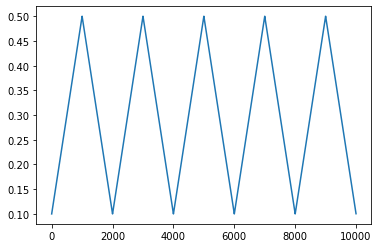

In [16]:
plotCyclicLR(num_cycles=6,total_iterations=10000, min_lr=0.1, max_lr=0.5, step_size=1000)

# Implementation of One cycle policy

In [17]:
!pip install torch-lr-finder -v --global-option="amp"

/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-dn7eftl1
Created temporary directory: /tmp/pip-req-tracker-qs6u3mtv
Created requirements tracker '/tmp/pip-req-tracker-qs6u3mtv'
Created temporary directory: /tmp/pip-install-5n5uga0q
Cleaning up...
Removed build tracker '/tmp/pip-req-tracker-qs6u3mtv'


Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


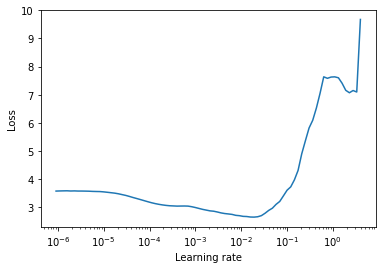

In [18]:
# LR range test
from torch_lr_finder import LRFinder
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, momentum=0.9)

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_dl, start_lr=1e-7,end_lr=10, num_iter=100, step_mode="exp")
lr_finder.plot(log_lr=True)
lr_finder.reset()

In [19]:
print('Min loss value is : {} \nMin LR value is   : {}'.format(min(lr_finder.history['loss']),format(min(lr_finder.history['lr']),'.10f')))

print('Min loss observed at index : {}'.format(lr_finder.history['loss'].index(min(lr_finder.history['loss']))))
print('so corresponding LR value at that index is--> LRmax : {}'.format(lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]))
lrmax = lr_finder.history['lr'][lr_finder.history['loss'].index(min(lr_finder.history['loss']))]
lrmax = float('{:4f}'.format(lrmax))
print(lrmax)

Min loss value is : 2.650279612739356 
Min LR value is   : 0.0000001445
Min loss observed at index : 64
so corresponding LR value at that index is--> LRmax : 0.019054607179632484
0.019055


In [0]:
from torch.optim.lr_scheduler import OneCycleLR

#optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

scheduler = OneCycleLR(optimizer, max_lr = lrmax, total_steps=None, epochs=
                       24, steps_per_epoch=1, pct_start=(5.0/24.0), anneal_strategy='linear', 
                       cycle_momentum=True, base_momentum=0.85, max_momentum=0.95, div_factor=10.0)

In [0]:
trainaccuracies = []
trainlosses = []
vallosses = []
valaccuracies = []

EPOCHS = 24
lr_values = []

In [22]:
from lib import trainTestMethods
for epoch in range(1,25):
    print("EPOCH:", epoch,'LR:',optimizer.param_groups[0]['lr'])
    lr_values.append(optimizer.param_groups[0]['lr'])
    trainTestMethods.train(model, train_dl, device, optimizer, criterion, epoch)
    scheduler.step()
    trainTestMethods.test(model, valid_dl, device, criterion, epoch)

EPOCH: 1 LR: 0.0019054999999999999

Epoch: 1
 [================================================================>]  Step: 160ms | Tot: 26s805ms | Train >> Loss: 1.840 | Acc: 36.034% (18017/50000) 98/98 
 [=============================================================>...]  Step: 35ms | Tot: 1s398ms | Test >> Loss: 1.287 | Acc: 53.330% (5333/10000) 20/20 
EPOCH: 2 LR: 0.006192875

Epoch: 2
 [================================================================>]  Step: 155ms | Tot: 26s712ms | Train >> Loss: 1.240 | Acc: 55.672% (27836/50000) 98/98 
 [=============================================================>...]  Step: 35ms | Tot: 1s358ms | Test >> Loss: 1.009 | Acc: 65.260% (6526/10000) 20/20 
EPOCH: 3 LR: 0.010480249999999998

Epoch: 3
 [================================================================>]  Step: 158ms | Tot: 26s640ms | Train >> Loss: 1.031 | Acc: 63.932% (31966/50000) 98/98 
 [=============================================================>...]  Step: 36ms | Tot: 1s385ms | T